In [21]:
# allow to import modules from the project root directory
import sys
import os
# Add the project root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.ParObsSnakeEnv import ParObsSnakeEnv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils import compute_metrics

In [23]:
# Simple Actor-Critic implementation
# Version №1
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.Dropout(x)
        logits = self.fc2(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [30]:
# Updated Actor-Critic implementation (more complex)
# Version №2
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.Dropout(x)
        logits = self.fc4(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        value = self.fc4(x)
        return value

In [15]:
# Version №3
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        logits = torch.relu(self.fc3(x))
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 256)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        value = torch.relu(self.fc3(x))
        return value

In [31]:
env = ParObsSnakeEnv(grid_size=10, interact=False)
num_actions = env.action_space.n
num_inputs = env.observation_space.shape[0]

In [32]:
gamma = 0.99
actor_lr = 0.0001
critic_lr = 0.0001
num_episodes = 5000

In [ ]:
actor = Actor(num_inputs, num_actions)
critic = Critic(num_inputs)
criterion = nn.MSELoss()
episode_reward_list = list()

In [21]:
# Initialize optimizers and learning rate schedulers
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

In [22]:
# Initialize lists to store statistics
actor_losses = []
critic_losses = []
episode_rewards = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Training Episodes"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action, action_probs = actor.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if done:
            reward = -1

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        value = critic(state_tensor)
        next_value = critic(next_state_tensor)

        target_value = reward + gamma * next_value * (1 - int(done))
        advantage = target_value - value

        actor_loss = -torch.log(action_probs[0, action]) * advantage.item()
        critic_loss = criterion(value, target_value.detach())

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()

        state = next_state

    # Store statistics
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    episode_rewards.append(episode_reward)

Training Episodes: 100%|██████████| 5000/5000 [21:51<00:00,  3.81it/s]


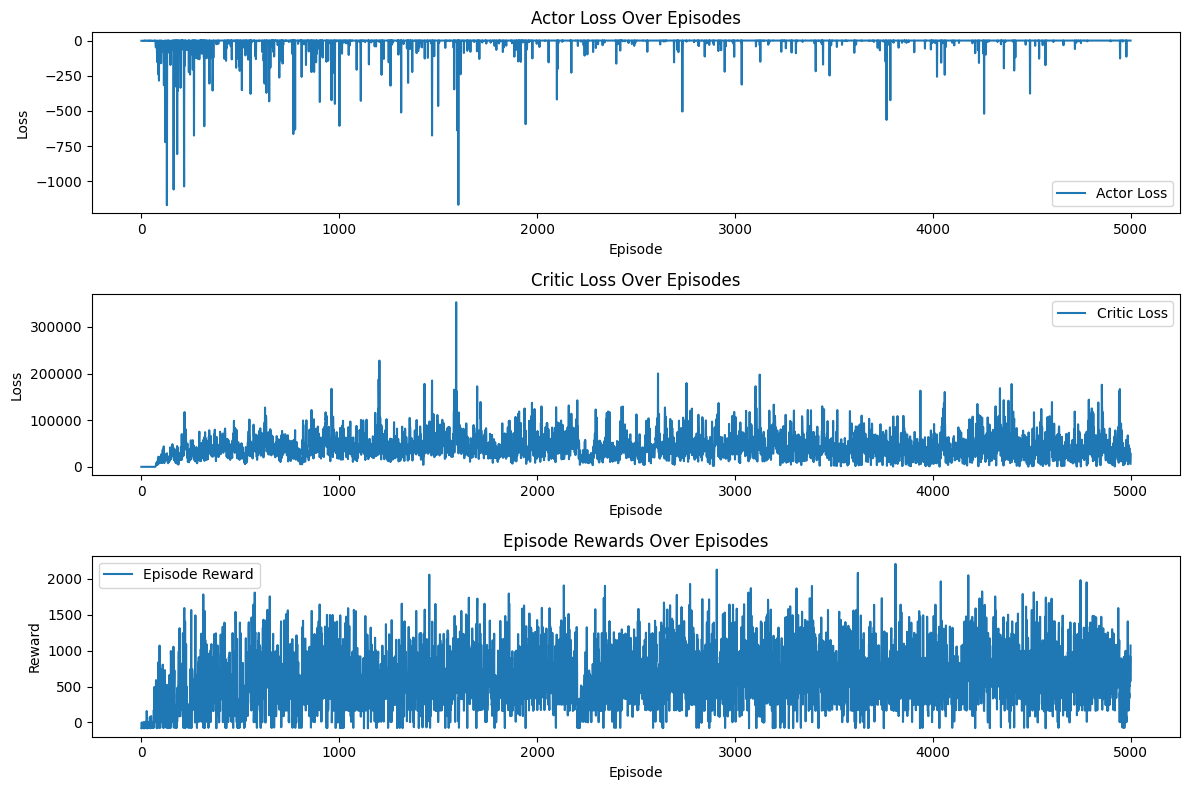

In [24]:
# Plotting the statistics
plt.figure(figsize=(12, 8))

# Plot actor losses
plt.subplot(3, 1, 1)
plt.plot(actor_losses, label='Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Actor Loss Over Episodes')
plt.legend()

# Plot critic losses
plt.subplot(3, 1, 2)
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Critic Loss Over Episodes')
plt.legend()

# Plot episode rewards
plt.subplot(3, 1, 3)
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Episodes')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
env = ParObsSnakeEnv(grid_size=20, interact=False)

In [28]:
from src.utils import compute_metrics

In [35]:
stats = compute_metrics(actor, env, "../../artifacts/models_stats/actor_critic/actor_critic_v2_sim.json", num_simulations=100)

  2%|▏         | 2/100 [00:00<00:07, 12.88it/s]

Snake length: 9, Episode reward: 654
Snake length: 14, Episode reward: 1072
Snake length: 7, Episode reward: 509


  4%|▍         | 4/100 [00:00<00:07, 13.47it/s]

Snake length: 18, Episode reward: 1413


  6%|▌         | 6/100 [00:00<00:09, 10.44it/s]

Snake length: 31, Episode reward: 2624
Snake length: 6, Episode reward: 345


  8%|▊         | 8/100 [00:00<00:10,  8.61it/s]

Snake length: 19, Episode reward: 1516
Snake length: 14, Episode reward: 1079
Snake length: 5, Episode reward: 276
Snake length: 10, Episode reward: 685


 11%|█         | 11/100 [00:00<00:07, 11.45it/s]

Snake length: 13, Episode reward: 1039
Snake length: 9, Episode reward: 613


 15%|█▌        | 15/100 [00:01<00:07, 10.85it/s]

Snake length: 21, Episode reward: 1733
Snake length: 16, Episode reward: 1264
Snake length: 9, Episode reward: 655


 19%|█▉        | 19/100 [00:01<00:05, 13.52it/s]

Snake length: 7, Episode reward: 470
Snake length: 11, Episode reward: 828
Snake length: 20, Episode reward: 1591
Snake length: 5, Episode reward: 260


 21%|██        | 21/100 [00:01<00:05, 14.21it/s]

Snake length: 12, Episode reward: 893
Snake length: 8, Episode reward: 560
Snake length: 21, Episode reward: 1732


 25%|██▌       | 25/100 [00:02<00:05, 13.12it/s]

Snake length: 8, Episode reward: 534
Snake length: 14, Episode reward: 1086
Snake length: 18, Episode reward: 1420


 27%|██▋       | 27/100 [00:02<00:07, 10.23it/s]

Snake length: 23, Episode reward: 1931
Snake length: 23, Episode reward: 1856
Snake length: 12, Episode reward: 896


 29%|██▉       | 29/100 [00:02<00:06, 11.39it/s]

Snake length: 8, Episode reward: 545
Snake length: 12, Episode reward: 925


 31%|███       | 31/100 [00:02<00:06,  9.91it/s]

Snake length: 13, Episode reward: 999
Snake length: 22, Episode reward: 1783


 35%|███▌      | 35/100 [00:03<00:05, 11.44it/s]

Snake length: 11, Episode reward: 828
Snake length: 15, Episode reward: 1137
Snake length: 8, Episode reward: 514
Snake length: 11, Episode reward: 850


 39%|███▉      | 39/100 [00:03<00:05, 11.44it/s]

Snake length: 13, Episode reward: 978
Snake length: 14, Episode reward: 1101
Snake length: 12, Episode reward: 932


 41%|████      | 41/100 [00:03<00:05, 10.88it/s]

Snake length: 10, Episode reward: 729
Snake length: 25, Episode reward: 2052


 43%|████▎     | 43/100 [00:03<00:05, 10.97it/s]

Snake length: 21, Episode reward: 1737
Snake length: 5, Episode reward: 275
Snake length: 4, Episode reward: 188
Snake length: 9, Episode reward: 650


 46%|████▌     | 46/100 [00:03<00:04, 12.28it/s]

Snake length: 17, Episode reward: 1369
Snake length: 16, Episode reward: 1254


 50%|█████     | 50/100 [00:04<00:03, 12.81it/s]

Snake length: 18, Episode reward: 1455
Snake length: 6, Episode reward: 360
Snake length: 16, Episode reward: 1226
Snake length: 8, Episode reward: 576
Snake length: 11, Episode reward: 763


 55%|█████▌    | 55/100 [00:04<00:03, 12.35it/s]

Snake length: 13, Episode reward: 1041
Snake length: 20, Episode reward: 1607
Snake length: 13, Episode reward: 998


 57%|█████▋    | 57/100 [00:04<00:03, 12.11it/s]

Snake length: 7, Episode reward: 487
Snake length: 16, Episode reward: 1290


 61%|██████    | 61/100 [00:05<00:03, 11.15it/s]

Snake length: 17, Episode reward: 1397
Snake length: 16, Episode reward: 1259
Snake length: 6, Episode reward: 366
Snake length: 9, Episode reward: 686


 63%|██████▎   | 63/100 [00:05<00:03, 11.09it/s]

Snake length: 21, Episode reward: 1668
Snake length: 9, Episode reward: 665
Snake length: 16, Episode reward: 1224


 67%|██████▋   | 67/100 [00:05<00:02, 13.22it/s]

Snake length: 7, Episode reward: 462
Snake length: 14, Episode reward: 1075
Snake length: 5, Episode reward: 276


 71%|███████   | 71/100 [00:06<00:02, 13.18it/s]

Snake length: 16, Episode reward: 1295
Snake length: 8, Episode reward: 525
Snake length: 9, Episode reward: 609
Snake length: 18, Episode reward: 1425


 73%|███████▎  | 73/100 [00:06<00:02, 11.06it/s]

Snake length: 19, Episode reward: 1504
Snake length: 22, Episode reward: 1790
Snake length: 8, Episode reward: 576


 78%|███████▊  | 78/100 [00:06<00:01, 14.99it/s]

Snake length: 7, Episode reward: 438
Snake length: 4, Episode reward: 185
Snake length: 11, Episode reward: 786
Snake length: 11, Episode reward: 826
Snake length: 4, Episode reward: 186


 82%|████████▏ | 82/100 [00:06<00:01, 15.43it/s]

Snake length: 16, Episode reward: 1266
Snake length: 10, Episode reward: 725
Snake length: 12, Episode reward: 884


 84%|████████▍ | 84/100 [00:07<00:01, 12.31it/s]

Snake length: 35, Episode reward: 2934
Snake length: 6, Episode reward: 355
Snake length: 13, Episode reward: 965


 88%|████████▊ | 88/100 [00:07<00:00, 12.21it/s]

Snake length: 15, Episode reward: 1160
Snake length: 10, Episode reward: 688
Snake length: 11, Episode reward: 791
Snake length: 5, Episode reward: 284
Snake length: 11, Episode reward: 834


 93%|█████████▎| 93/100 [00:07<00:00, 12.93it/s]

Snake length: 10, Episode reward: 708
Snake length: 17, Episode reward: 1335
Snake length: 15, Episode reward: 1159


 95%|█████████▌| 95/100 [00:07<00:00, 11.81it/s]

Snake length: 4, Episode reward: 189
Snake length: 29, Episode reward: 2430


 97%|█████████▋| 97/100 [00:08<00:00, 12.32it/s]

Snake length: 8, Episode reward: 516
Snake length: 14, Episode reward: 1093
Snake length: 6, Episode reward: 388


100%|██████████| 100/100 [00:08<00:00, 11.97it/s]

Snake length: 20, Episode reward: 1613
Snake length: 14, Episode reward: 1031


In [36]:
snake_lengths = stats['snake_lengths']
episode_rewards = stats['episode_rewards']

Average Snake Length: 12.95
Average Episode Reward: 987.54


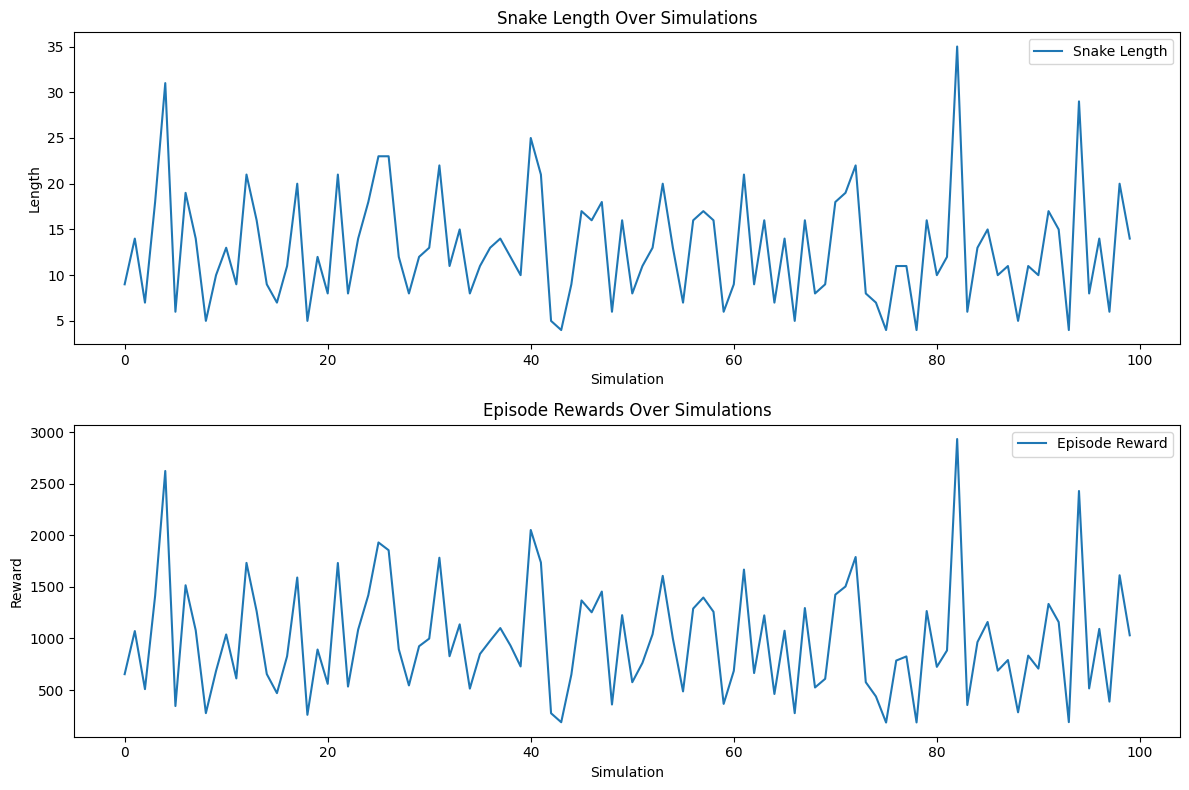

In [37]:
# Print metrics
print("Average Snake Length:", np.mean(snake_lengths))
print("Average Episode Reward:", np.mean(episode_rewards))

# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plot snake lengths
plt.subplot(2, 1, 1)
plt.plot(snake_lengths, label='Snake Length')
plt.xlabel('Simulation')
plt.ylabel('Length')
plt.title('Snake Length Over Simulations')
plt.legend()

# Plot episode rewards
plt.subplot(2, 1, 2)
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Simulation')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Simulations')
plt.legend()

plt.tight_layout()
plt.show()